## Image Captioning using LSTM and CNN

In [1]:
import tensorflow as tf
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [2]:
import tensorflow as tf
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import cv2
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

## Extracting Image Features

In [3]:
#load vgg16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [4]:
directory = r"C:\Users\lenovo\Downloads\Flicker\flickr30k-images"
dir_Flickr_text = r"C:\Users\lenovo\Downloads\Flicker\results_20130124.token"
jpgs = os.listdir(directory)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 31783


In [ ]:
# extarct the feature from the image
features = {}
for img_name in tqdm(os.listdir(directory)):
    # load the image file
    img_path = directory  + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    # converts image pixels to numpy array
    image = img_to_array(image)
    #image reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    # The features are stored in the dictionary using the image ID as the key.
    features[image_id]=feature

In [ ]:
WORKING_DIR = r'C:\Users\lenovo\Downloads\Flicker\Features_pickle'
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [5]:
# load features from pickle
WORKING_DIR = r'C:\Users\lenovo\Downloads\Flicker\Features_pickle'
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [6]:
# Load caption
with open(dir_Flickr_text, 'r',encoding='utf-8') as f:
    captions_doc = f.read()

## Reading and cleaning captions

In [7]:
# Split the data into each line, to get a list of captions
captions = captions_doc.split('\n')
# Remove the last line since it is blank
captions = captions[:-1]

In [8]:
print("Total number of caption = " + str(len(captions)))

Total number of caption = 158915


In [9]:
print(captions[-1])

998845445.jpg#4	A man on a moored blue and white boat with hills and mist in the background .


In [10]:
# Store the captions in a dictionary
# Each imageID will be mapped to a list of its captions

content = {}

for line in captions:
    imageID, caption = line.split('\t')

    imageID = imageID.split('.')[0]

    # If the imageID doesn't exist in the dictionary, create a blank entry
    if content.get(imageID) is None:
        content[imageID] = []

    # Append the current caption to the list of the corresponding image
    content[imageID].append(caption)

In [11]:
#cross-checking the mapping
print(content[captions[0].split('.')[0]])

['Two young guys with shaggy hair look at their hands while hanging out in the yard .', 'Two young , White males are outside near many bushes .', 'Two men in green shirts are standing in a yard .', 'A man in a blue shirt standing in a garden .', 'Two friends enjoy time spent together .']


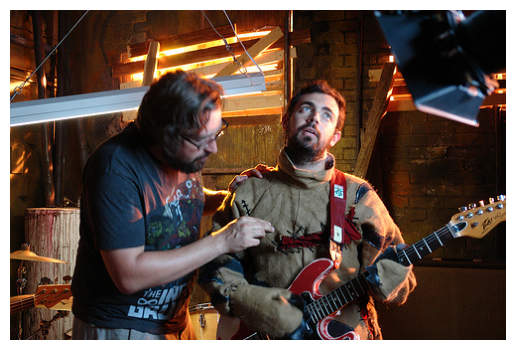

CAPTIONS - 
Two people in the photo are playing the guitar and the other is poking at him .
A man in green holds a guitar while the other man observes his shirt .
A man is fixing the guitar players costume .
a guy stitching up another man 's coat .
the two boys playing guitar


In [12]:
#Check that the captions have been mapped correctly

# Choose a random number, say 25

IMG_PATH = r"C:\Users\lenovo\Downloads\Flicker\flickr30k-images"
image_id = captions[25].split('.')[0]

img = cv2.imread(IMG_PATH + '\\' + image_id + ".jpg")
# This converts the image from BGR color space to RGB color space, which is the format used by Matplotlib.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
# This displays the image using Matplotlib.
plt.imshow(img)
# This turns off axis labels and ticks for the plot. 
plt.axis("off")
#This shows the plotted image.
plt.show()

print("CAPTIONS - ")
for caption in content[image_id]:
    print(caption)

## preprocess caption function 

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one captin at a time
            caption = captions[i]
            # preprocessing text
            # convert to lower case
            caption = caption.lower()
            # delete digits and special characters etc.,
            caption = caption.replace('^[A-Za-z]','')
            # delete addtional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1])  + ' endseq'
            #Replace the original caption with the preprocessed caption
            captions[i]= caption

In [14]:
clean(content)

In [15]:
content['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [16]:
#gather all captions in one place
all_captions = []
for key in content:
    for caption in content[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

158915

In [18]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

# tokenize the text

In [19]:
# This tokenizer can be used to convert text into sequences of integers, which can then be used as input for training the model.
tokenizer = Tokenizer()
# After fitting tokenizer on texts,This step processes the captions and builds the vocabulary based on the words in the captions.
tokenizer.fit_on_texts(all_captions)

# Define the file path where you want to save the tokenizer
tokenizer_file_path = r"C:\Users\lenovo\Downloads\tokenizer.pkl"

# Save the tokenizer to the specified file path
with open(tokenizer_file_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [21]:
# Define the file path from where you want to load the tokenizer
tokenizer_file_path = r"C:\Users\lenovo\Downloads\tokenizer.pkl"

# Load the tokenizer from the specified file path
with open(tokenizer_file_path, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# we will use the loaded tokenizer for text encoding

In [22]:
# number of unique words in the tokenizer's word index.
vocab_size=len(tokenizer.word_index)+1
vocab_size
#The vocab_size value is important when defining the embedding layer of a neural network, 
# as it determines the number of input nodes in that layer.
#vectors of real number

18057

In [23]:
# get maximum length of the captions avilable
max_length = max(len(caption.split()) for caption in all_captions)
max_length
#efficient batch processing and avoiding memory issues during training(may be loss of info. if truncation occur)

74

# **Train - Test Split**

In [24]:
image_ids = list(content.keys())
split=int(len(image_ids)*0.85)
train= image_ids[:split]
test=image_ids[split:]

In [25]:
len(train),len(test)

(27015, 4768)

In [26]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]  
                #[0] is used to extract the first (and only) sequence from the list.
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    # These pairs are useful for tasks like training a model to predict the next word in a sequence.
                    in_seq, out_seq = seq[:i], seq[i]
                    #  pad the input sequence with zero to a specified maximum length.
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0]) #The image feature vector associated with the current key (image ID) is appended to the X1 list. 
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0
            #The yield statement generates a batch of data in the form of two inputs ([X1, X2]) and a target (y).

## Model creation

In [27]:
import pydot

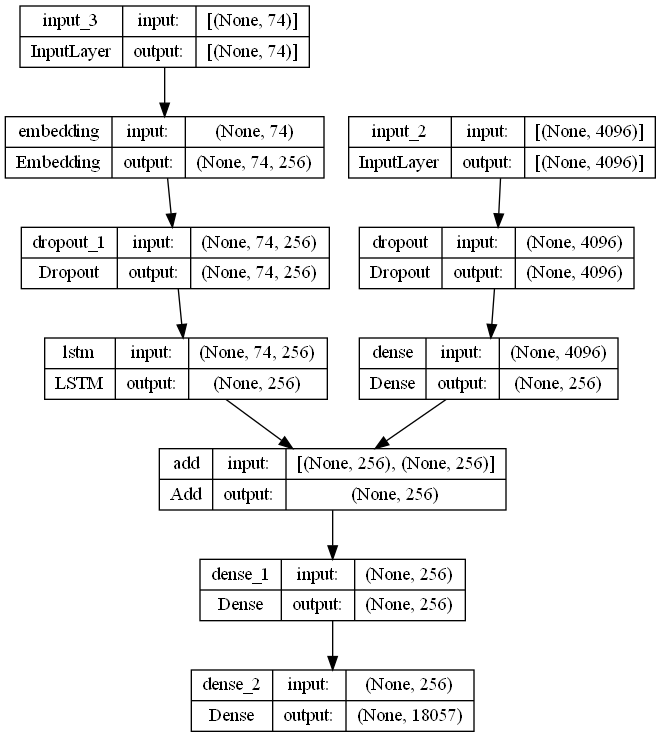

In [28]:
## encoder model
# image feature layers
#Input layer for the image features.
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
## sequence feature layers
#Input layer for the caption sequences
inputs2 = Input(shape=(max_length,))
#Embedding layer enables us to convert each word into a fixed length vector of defined size.
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
#This layer processes the embedded sequences and outputs a context vector.(similar meaning ~ same context vector )
se3 = LSTM(256)(se2)

## decoder model
#combining the image and sequence features.
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

#The complete captioning model, taking both image features and caption sequences as inputs and
# producing the predicted word probabilities as outputs.
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
#Compiles the model with categorical cross-entropy loss (suitable for multi-class classification tasks) 
# and the Adam optimizer.
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 20
batch_size = 32
# The number of batches per epoch:STEPS
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, content, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch(steps_per_epoch parameter specifies the number of batches to use from the generator for one epoch.)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# save the model
WORKING_DIR=r"C:\Users\lenovo\Downloads\Flicker"
model.save(WORKING_DIR+'\\best_model_collab.h5')

In [29]:
import keras
WORKING_DIR=r"C:\Users\lenovo\Downloads\Flicker"
model = keras.models.load_model(WORKING_DIR+'\\best_model_collab.h5')

# Generate Captions for the Image

In [30]:
# retrieve the word associated with a specific integer index from the tokenizer's vocabulary.
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [31]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generaation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_length)
        # predict next word(Predicts the next word's probability distribution using the model.)
        yhat = model.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" "+word
                # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

## BLEU score 
 (Bilingual Evaluation Understudy) metric

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions= content[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    #split ino words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score (unigram and bigram precision)
print("BLEU-1:%f"% corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2:%f"% corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

# Visualize the Results

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = ""
    image_id = image_name.split('.')[0]
    dir_path = r"C:\Users\lenovo\Downloads\Flicker"
    
    img_path = os.path.join(dir_path,"flickr30k-images", image_name)
    image = Image.open(img_path)
    captions = content[image_id]
    print('-------------Actual------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------Predicted---------------')
    print(y_pred)
    plt.imshow(image)

-------------Actual------------
startseq two children girl and boy are practicing their writing endseq
startseq two children sit on small seesaw in the sand endseq
startseq two children sitting on teeter totter endseq
startseq kids playing on seesaw endseq
startseq two kids sit on seesaw endseq
--------------Predicted---------------
startseq two people are sitting on the ground in front of large building endseq


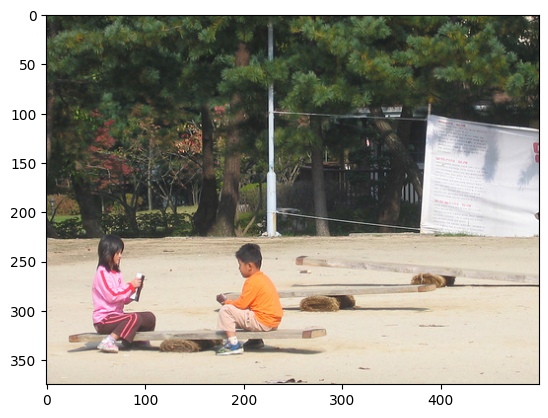

In [33]:
generate_caption("1006452823.jpg")

-------------Actual------------
startseq man and woman search for records while man in blue hooded shirt looks in the other direction endseq
startseq man and women look through milk crates full of records or pictures on sale endseq
startseq man and woman look through cd 's at street vendor endseq
startseq crowd is busy looking to buy something endseq
startseq people are looking at records endseq
--------------Predicted---------------
startseq man in blue shirt and jeans is standing in front of crowd of people endseq


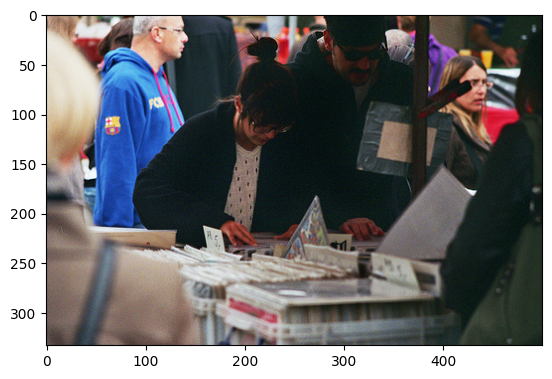

In [34]:
generate_caption("7466310132.jpg")

## Real Time image


In [35]:
vgg_model=VGG16()
vgg_model = Model(inputs=vgg_model.inputs,outputs=vgg_model.layers[-2].output)

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
def real_image_test(image_path):

  image_real = Image.open(image_path)
  #load image
  image = load_img(image_path,target_size=(224,224))
  #convert image pixels to numpy array
  image = img_to_array(image)
  #reshape data for model
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  # preprocess image for vgg
  image = preprocess_input(image)
  # extract features
  features = vgg_model.predict(image,verbose=1)
  # predict from the trained model
  print(predict_caption(model,features,tokenizer,max_length))
  plt.imshow(image_real)

1/1 [==============================] - 0s 340ms/step
startseq dog leaps over the grass endseq


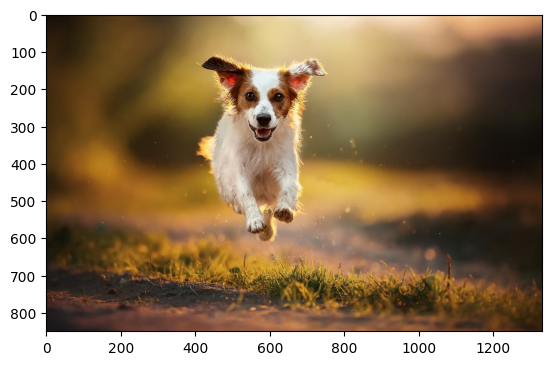

In [37]:
image_path=r"C:\Users\lenovo\Downloads\6554515.jpg"
real_image_test(image_path)

1/1 [==============================] - 0s 170ms/step
startseq football team is wearing red and white endseq


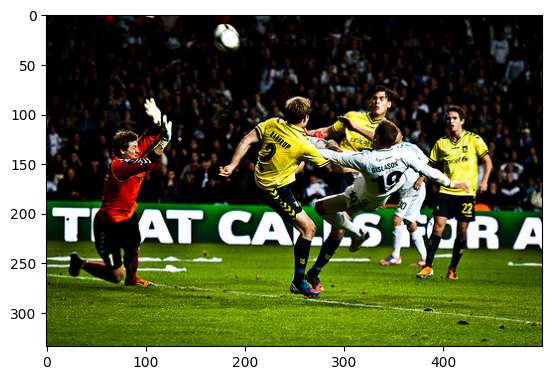

In [38]:
image_path=r"C:\Users\lenovo\Downloads\8110271708.jpg"
real_image_test(image_path)